# Исследование зависимости обучения сети от margin параметра Contrastive Loss

Обучение сиамских сетей на наборе MOT20_ext (2 пары). Используемая функция потерь - Contrastive Loss. Будет произведено обучение нескольких моделей на разных margin и выявлена зависимость обучения от margin

_другие гиперпараметры были подобраны ранее_

In [1]:
import albumentations as A
import torch
from torch.optim import Adam
import pandas as pd
from os.path import join
import matplotlib.pyplot as plt

from src.config import MOT20_EXT_FIRST_AXIS_MEAN, MOT20_EXT_SECOND_AXIS_MEAN, RESULTS_PATH
from src.models import SiameseBasicCNN
from src.models.reidentification import SiameseBasicCNN
from src.train import ContrastiveLoss, get_config, get_loaders, train_siamese
from src.train.loss import ContrastiveLoss
from src.transforms import get_norm_transform, get_resize_transform

## Загрузка датасета

In [2]:
dataset_config = get_config('mot20_ext-v1c')
dataset_config

{'dataset_config': 'mot20_ext-v1c',
 'dataset': 'mot20_ext',
 'dataset_use': 0.01,
 'test_proportion': 0.15,
 'val_proportion': 0.2,
 'test_proportion.1': nan,
 'batch_size': 16,
 'extra_parameters': {'visibility_threshold': 1.0,
  'negative_proportion': 0.5,
  'frame_distance': 0}}

In [3]:
resize_transform = get_resize_transform((MOT20_EXT_FIRST_AXIS_MEAN, MOT20_EXT_SECOND_AXIS_MEAN)) 
norm_transform = get_norm_transform()
transform = A.Compose([resize_transform, norm_transform])

In [4]:
train_loader, val_loader, test_loader = get_loaders(dataset_config, transform=transform)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Определить примерные границы margin

### Basic CNN, margin=0.001

In [6]:
model = SiameseBasicCNN().to(device)
lr = 1e-2
optimizer = Adam(model.parameters(), lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
criterion = ContrastiveLoss(margin=0.001)

model, results = train_siamese(
    config=dataset_config,
    criterion=criterion,
    device=device,
    epoch_count=6,
    lr=lr,
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    threshold=0.25,
    train_loader=train_loader,
    val_loader=val_loader,
)

Epoch 0/5:


/home/nick/reidentification/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
100%|██████████| 110/110 [00:17<00:00,  6.30it/s]

train Loss: 0.0292 Acc: 0.7415



100%|██████████| 33/33 [00:01<00:00, 20.98it/s]

val Loss: 0.0046 Acc: 0.7652


Model saved at basic_cnn.pth
Epoch 1/5:


100%|██████████| 110/110 [00:16<00:00,  6.80it/s]

train Loss: 0.0004 Acc: 0.7347



100%|██████████| 33/33 [00:01<00:00, 22.05it/s]

val Loss: 0.0000 Acc: 0.8295
Model saved at basic_cnn.pth
Epoch 2/5:



 30%|███       | 33/110 [00:04<00:11,  6.77it/s]


KeyboardInterrupt: 

### Basic CNN, margin=0.01

In [7]:
model = SiameseBasicCNN().to(device)
lr = 1e-2
optimizer = Adam(model.parameters(), lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
criterion = ContrastiveLoss(margin=0.01)

model, results = train_siamese(
    config=dataset_config,
    criterion=criterion,
    device=device,
    epoch_count=6,
    lr=lr,
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    threshold=0.25,
    train_loader=train_loader,
    val_loader=val_loader,
)

Epoch 0/5:


100%|██████████| 110/110 [00:16<00:00,  6.82it/s]

train Loss: 0.0313 Acc: 0.7807



100%|██████████| 33/33 [00:01<00:00, 22.50it/s]

val Loss: 0.0001 Acc: 0.8712
Model saved at basic_cnn.pth
Epoch 1/5:



100%|██████████| 110/110 [00:16<00:00,  6.80it/s]

train Loss: 0.0000 Acc: 0.7102



100%|██████████| 33/33 [00:01<00:00, 22.62it/s]

val Loss: 0.0000 Acc: 0.8352
Epoch 2/5:



  9%|▉         | 10/110 [00:01<00:16,  6.18it/s]


KeyboardInterrupt: 

### Basic CNN, margin=0.1

In [8]:
model = SiameseBasicCNN().to(device)
lr = 1e-2
optimizer = Adam(model.parameters(), lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
criterion = ContrastiveLoss(margin=0.1)

model, results = train_siamese(
    config=dataset_config,
    criterion=criterion,
    device=device,
    epoch_count=6,
    lr=lr,
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    threshold=0.25,
    train_loader=train_loader,
    val_loader=val_loader,
)

Epoch 0/5:


100%|██████████| 110/110 [00:16<00:00,  6.76it/s]

train Loss: 0.0475 Acc: 0.7466



100%|██████████| 33/33 [00:01<00:00, 22.29it/s]

val Loss: 0.0050 Acc: 0.8485
Model saved at basic_cnn.pth
Epoch 1/5:



100%|██████████| 110/110 [00:16<00:00,  6.84it/s]

train Loss: 0.0035 Acc: 0.7824



100%|██████████| 33/33 [00:01<00:00, 22.08it/s]

val Loss: 0.0040 Acc: 0.8864
Model saved at basic_cnn.pth
Epoch 2/5:



100%|██████████| 110/110 [00:16<00:00,  6.82it/s]

train Loss: 0.0034 Acc: 0.8136



100%|██████████| 33/33 [00:01<00:00, 22.48it/s]

val Loss: 0.0044 Acc: 0.8580
Epoch 3/5:



 15%|█▌        | 17/110 [00:02<00:14,  6.46it/s]


KeyboardInterrupt: 

### Basic CNN, margin=0.5

In [9]:
model = SiameseBasicCNN().to(device)
lr = 1e-2
optimizer = Adam(model.parameters(), lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
criterion = ContrastiveLoss(margin=0.5)

model, results = train_siamese(
    config=dataset_config,
    criterion=criterion,
    device=device,
    epoch_count=6,
    lr=lr,
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    threshold=0.25,
    train_loader=train_loader,
    val_loader=val_loader,
)

Epoch 0/5:


100%|██████████| 110/110 [00:16<00:00,  6.85it/s]

train Loss: 0.1223 Acc: 0.7727



100%|██████████| 33/33 [00:01<00:00, 22.12it/s]

val Loss: 0.1037 Acc: 0.8580
Model saved at basic_cnn.pth
Epoch 1/5:



100%|██████████| 110/110 [00:16<00:00,  6.83it/s]

train Loss: 0.0850 Acc: 0.8000



100%|██████████| 33/33 [00:01<00:00, 22.41it/s]

val Loss: 0.0977 Acc: 0.9186
Model saved at basic_cnn.pth
Epoch 2/5:



100%|██████████| 110/110 [00:16<00:00,  6.83it/s]

train Loss: 0.0857 Acc: 0.7966



100%|██████████| 33/33 [00:01<00:00, 23.13it/s]

val Loss: 0.0975 Acc: 0.8996
Epoch 3/5:



100%|██████████| 110/110 [00:16<00:00,  6.82it/s]

train Loss: 0.0836 Acc: 0.8114



100%|██████████| 33/33 [00:01<00:00, 21.92it/s]

val Loss: 0.0966 Acc: 0.9299
Model saved at basic_cnn.pth
Epoch 4/5:



100%|██████████| 110/110 [00:16<00:00,  6.86it/s]

train Loss: 0.0845 Acc: 0.7795



100%|██████████| 33/33 [00:01<00:00, 23.15it/s]

val Loss: 0.0946 Acc: 0.9186
Epoch 5/5:



100%|██████████| 110/110 [00:16<00:00,  6.84it/s]

train Loss: 0.0847 Acc: 0.8284



100%|██████████| 33/33 [00:01<00:00, 22.01it/s]

val Loss: 0.0960 Acc: 0.9034


## Подбор параметра

In [ ]:
for m in range(1, 6):
    model = SiameseBasicCNN().to(device)
    lr = 1e-2
    optimizer = Adam(model.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
    criterion = ContrastiveLoss(margin=m)

    model, results = train_siamese(
        config=dataset_config,
        criterion=criterion,
        device=device,
        epoch_count=6,
        lr=lr,
        model=model,
        optimizer=optimizer,
        scheduler=scheduler,
        threshold=0.25,
        train_loader=train_loader,
        val_loader=val_loader,
    )

### Интерпретация

In [49]:
df = pd.read_csv(join(RESULTS_PATH, 'experiments.csv'))
res1 = df[(df['datetime'] > '2023-05-17 16:13:29') & (df['datetime'] < '2023-05-17 16:24')]
res1

,model_name,datetime,epoch_count,optimizer,lr,gamma,step_size,loss_name,val_losses,val_accuracies,best_val_acc,best_val_loss,test_accuracy,dataset_config,extra_parameters,train_losses,train_accuracies
10,basic_cnn,2023-05-17 16:13:29.995821,6,Adam,0.01,0.1,2.0,ContrastiveLoss m=0.5,0.10366702621633356;0.09767509500185649;0.0975...,0.8579545454545454;0.9185606060606061;0.899621...,0.929924,0.094597,NaN,mot20_ext-v1c,threshold=0.25,NaN,NaN
11,basic_cnn,2023-05-17 16:16:08.357209,6,Adam,0.01,0.1,2.0,ContrastiveLoss m=1,0.3937322163220608;0.38748486656131165;0.39237...,0.8920454545454546;0.8901515151515151;0.895833...,0.931818,0.375903,NaN,mot20_ext-v1c,threshold=0.25,NaN,NaN
12,basic_cnn,2023-05-17 16:18:12.320181,6,Adam,0.01,0.1,2.0,ContrastiveLoss m=2,1.6220077167857776;1.501405044035478;1.5712510...,0.8200757575757576;0.9015151515151515;0.922348...,0.928030,1.484149,NaN,mot20_ext-v1c,threshold=0.25,NaN,NaN
13,basic_cnn,2023-05-17 16:19:21.640774,6,Adam,0.01,0.1,2.0,ContrastiveLoss m=3,3.7105082381855357;3.536945205746275;3.4418311...,0.8314393939393939;0.8939393939393939;0.922348...,0.922348,3.441831,NaN,mot20_ext-v1c,threshold=0.25,NaN,NaN
14,basic_cnn,2023-05-17 16:21:27.245222,6,Adam,0.01,0.1,2.0,ContrastiveLoss m=4,6.333531899885698;6.176032673228871;6.33328749...,0.8712121212121212;0.9053030303030303;0.926136...,0.929924,6.133762,NaN,mot20_ext-v1c,threshold=0.25,NaN,NaN
15,basic_cnn,2023-05-17 16:23:15.268691,6,Adam,0.01,0.1,2.0,ContrastiveLoss m=5,9.332255450162021;9.461283712676078;9.44731449...,0.9223484848484849;0.9071969696969697;0.931818...,0.931818,9.222168,NaN,mot20_ext-v1c,threshold=0.25,NaN,NaN


In [53]:
margins = list(map(lambda x: float(x.split(' ')[1][2:]), list(res1['loss_name'])))
val_accuracies = list(res1['best_val_acc'])
val_losses = list(res1['best_val_loss'])

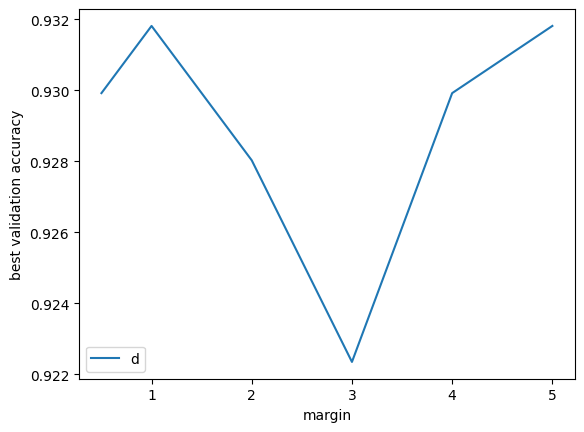

In [57]:
plt.plot(margins, val_accuracies)
plt.xlabel('margin')
plt.ylabel('best validation accuracy')

In [ ]:
for m in range(6, 10):
    model = SiameseBasicCNN().to(device)
    lr = 1e-2
    optimizer = Adam(model.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
    criterion = ContrastiveLoss(margin=m)

    model, results = train_siamese(
        config=dataset_config,
        criterion=criterion,
        device=device,
        epoch_count=6,
        lr=lr,
        model=model,
        optimizer=optimizer,
        scheduler=scheduler,
        threshold=0.25,
        train_loader=train_loader,
        val_loader=val_loader,
    )

In [10]:
df = pd.read_csv(join(RESULTS_PATH, 'experiments.csv'))
res2 = df[(df['datetime'] > '2023-05-17 16:13:29') & (df['datetime'] < '2023-05-17 21:04')]
res2

,model_name,datetime,epoch_count,optimizer,lr,gamma,step_size,loss_name,val_losses,val_accuracies,best_val_acc,best_val_loss,test_accuracy,dataset_config,extra_parameters,train_losses,train_accuracies
10,basic_cnn,2023-05-17 16:13:29.995821,6,Adam,0.01,0.1,2.0,ContrastiveLoss m=0.5,0.10366702621633356;0.09767509500185649;0.0975...,0.8579545454545454;0.9185606060606061;0.899621...,0.929924,0.094597,NaN,mot20_ext-v1c,threshold=0.25,NaN,NaN
11,basic_cnn,2023-05-17 16:16:08.357209,6,Adam,0.01,0.1,2.0,ContrastiveLoss m=1,0.3937322163220608;0.38748486656131165;0.39237...,0.8920454545454546;0.8901515151515151;0.895833...,0.931818,0.375903,NaN,mot20_ext-v1c,threshold=0.25,NaN,NaN
12,basic_cnn,2023-05-17 16:18:12.320181,6,Adam,0.01,0.1,2.0,ContrastiveLoss m=2,1.6220077167857776;1.501405044035478;1.5712510...,0.8200757575757576;0.9015151515151515;0.922348...,0.928030,1.484149,NaN,mot20_ext-v1c,threshold=0.25,NaN,NaN
13,basic_cnn,2023-05-17 16:19:21.640774,6,Adam,0.01,0.1,2.0,ContrastiveLoss m=3,3.7105082381855357;3.536945205746275;3.4418311...,0.8314393939393939;0.8939393939393939;0.922348...,0.922348,3.441831,NaN,mot20_ext-v1c,threshold=0.25,NaN,NaN
14,basic_cnn,2023-05-17 16:21:27.245222,6,Adam,0.01,0.1,2.0,ContrastiveLoss m=4,6.333531899885698;6.176032673228871;6.33328749...,0.8712121212121212;0.9053030303030303;0.926136...,0.929924,6.133762,NaN,mot20_ext-v1c,threshold=0.25,NaN,NaN
15,basic_cnn,2023-05-17 16:23:15.268691,6,Adam,0.01,0.1,2.0,ContrastiveLoss m=5,9.332255450162021;9.461283712676078;9.44731449...,0.9223484848484849;0.9071969696969697;0.931818...,0.931818,9.222168,NaN,mot20_ext-v1c,threshold=0.25,NaN,NaN
16,basic_cnn,2023-05-17 21:00:03.709968,6,Adam,0.01,0.1,2.0,ContrastiveLoss m=6,13.878573908950344;13.060300306840377;13.10220...,0.8939393939393939;0.9261363636363636;0.897727...,0.929924,13.051024,NaN,mot20_ext-v1c,threshold=0.25,13.192607082020153;12.551794164830989;12.40417...,0.8164772727272728;0.8204545454545454;0.813068...
17,basic_cnn,2023-05-17 21:01:33.411204,6,Adam,0.01,0.1,2.0,ContrastiveLoss m=7,18.079176021344733;18.220480572093617;18.08935...,0.8731060606060606;0.9147727272727273;0.916666...,0.924242,17.897235,NaN,mot20_ext-v1c,threshold=0.25,17.58050719174472;16.84292718713934;16.4055915...,0.8051136363636363;0.8454545454545455;0.841477...
18,basic_cnn,2023-05-17 21:02:54.414179,6,Adam,0.01,0.1,2.0,ContrastiveLoss m=8,22.80516474174731;23.3486483891805;23.63430419...,0.9034090909090909;0.8977272727272727;0.909090...,0.916667,22.805165,NaN,mot20_ext-v1c,threshold=0.25,22.975373545559968;21.979100903597747;22.10880...,0.8159090909090909;0.7761363636363636;0.775568...
19,basic_cnn,2023-05-17 21:03:34.423338,6,Adam,0.01,0.1,2.0,ContrastiveLoss m=9,30.34436826994925;29.567539272886336;29.090578...,0.928030303030303;0.9375;0.9034090909090909;0....,0.937500,29.090578,NaN,mot20_ext-v1c,threshold=0.25,28.716273047707297;27.45019069151445;27.528893...,0.8005681818181818;0.8181818181818182;0.805113...


In [11]:
margins = list(map(lambda x: float(x.split(' ')[1][2:]), list(res2['loss_name'])))
val_accuracies = list(res2['best_val_acc'])
val_losses = list(res2['best_val_loss'])

Text(0, 0.5, 'best validation accuracy')

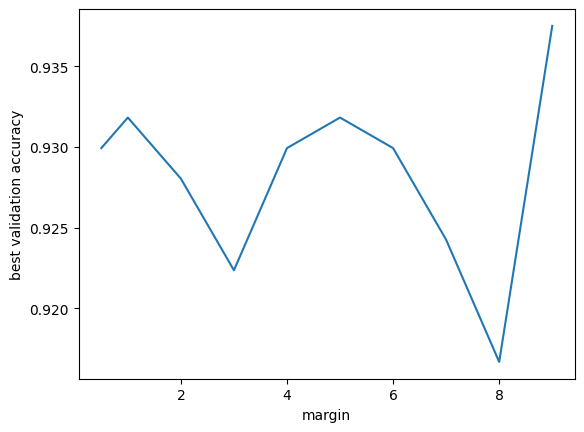

In [12]:
plt.plot(margins, val_accuracies)
plt.xlabel('margin')
plt.ylabel('best validation accuracy')